## Imports

In [3]:
import requests
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

I made a function below to allow me to connect the API and get the subreddit from reddit. I had two arguments in my function, subreddit is the subreddit that I'm interested in looking into and the before is the time period of the posts. I will add comments on top of each line of code to further explain what each line is looking at.

In [4]:
# function was created for the API
def redd_post(subreddit, before):
    # This is the link for the api pushshift
    subreddit_url = 'https://api.pushshift.io/reddit/search/submission?'
    # I just made sure that the before in which the number being pulled is for sure an int
    temp_bef = int(before)
    # I made parameters which include the subreddit i want, the number of posts I want to get out and the time period 
    #of the post
    params = {
    'subreddit': subreddit,
    'size': 100,
    'before': temp_bef,
    }
    # I made an open list as a variable
    resu = []
    # The fields are columns that I'm interested in looking at
    fields = 'subreddit,id,title,author,created_utc,selftext,is_self'
    # The forloop to be able to get more than 50 posts or how many I want.
    for i in range(50):
        #I hardcoded so that the subreddit, fields, and before are included in the url.
        res = requests.get(subreddit_url+"subreddit="+subreddit+"&fields="+fields+"&size=100"+'&before='+str(temp_bef))
        # make sure I get a 200 so I can retrieve the post.
        res.status_code
        # I made it into a json file and put it as a variable
        data = res.json()
        # I made a new variable name for the data
        posts = data['data']
        # 1 wanted to add the new posts to the listing variable resu 
        resu = resu + posts 
        # I made the time every other day since the unix epoch converter number started
        temp_bef = temp_bef-1440
        # To allow for some grace period I put time sleep
        time.sleep(2)
        # I made a dataframe of the list of resu. 
    return pd.DataFrame(resu)     

# Help from Rowan and Gabe

I chose the unix time that was provided when I was doing API push and thought I should go with the numbers that were provided for each of the data

In [5]:
nvidia_df = redd_post('Nvidia', 1664331212)
amd_df = redd_post('AMD',1664494998)

## Data Cleaning/EDA Analysis

I began by saving the csv files to the dataset folders

In [6]:
amd_df.to_csv('./Datasets/amd.csv', index = False)
nvidia_df.to_csv('./Datasets/nvidia.csv', index = False)

In [7]:
amd_df

,author,created_utc,id,is_self,selftext,subreddit,title
0,DefiantAbalone1,1664494156,xrm8vu,True,\n\n\n\n(Excerpted from: https://www.tomshardw...,Amd,A peekkind of performance potential Zen 5 FPGA...
1,Gramzzzz,1664494016,xrm71w,True,Ok I know this shit sucks. I have a recommenda...,Amd,X670 memory sticker
2,dvcspl,1664493812,xrm4et,True,Just upgraded today to 7900X/X670E Crosshair/G...,Amd,Holy long boot time.. 7900X
3,gamagama420,1664493071,xrluvh,True,if you uploaded it on yt youd probably get a d...,Amd,can someone with a zen 4 cpu run some rcps3 be...
4,Psythik,1664491907,xrlfqd,False,,Amd,I can confirm that there is no stupid sticker ...
...,...,...,...,...,...,...,...
4995,royalambiance,1664358201,xq88ze,False,,Amd,Consultancy and Project Management
4996,SpigettiSpiggooty,1664357642,xq83ag,True,Disclosure: This is my first post here and on ...,Amd,I'm trying to decide possible upgrade paths fo...
4997,royalambiance,1664357597,xq82ti,False,,Amd,Interior Design
4998,Neeville1,1664357356,xq8034,True,[removed],Amd,Intel adding more cores and threads is funny


I then concatenated the two files together to make one larger file

In [8]:
nvidia_amd = pd.concat([nvidia_df, amd_df])

I saved the new file to the datasets folder

In [9]:
nvidia_amd.to_csv('./Datasets/combined_dataframe.csv')

I began by making sure the columns are lowercase. 

In [10]:
nvidia_amd['title'] = nvidia_amd['title'].str.lower()
nvidia_amd['selftext'] = nvidia_amd['selftext'].str.lower()

I then went on to look at the null values for each of the columns to see if there were any. I only checked the concantenated file because I will be using this file throughout the entire project. As we can see, there were 23 selftexts that had null values. When comparing that to the 5000 rows that are in the dataset, this is less than 5% of the entire data

In [11]:
nvidia_amd.isnull().sum()

author          0
created_utc     0
id              0
is_self         0
selftext       23
subreddit       0
title           0
dtype: int64

To make sure the data is cleane and has information that is relevant. I first began looking at the title and wanted to get rid of rows that had [removed], if there are any rows in the title and selftext columns that just have a space, and then looking at notnull values as well. 

In [12]:
nvidia_amd = nvidia_amd[(nvidia_amd['title'].notnull()) & (len(nvidia_amd['title'].str.strip()) > 0) & (nvidia_amd['title'] != '[removed]')]
nvidia_amd = nvidia_amd[(nvidia_amd['selftext'].notnull()) & (len(nvidia_amd['selftext'].str.strip()) > 0) & (nvidia_amd['selftext'] != '[removed]')] 
# Help from Gabe

As we can see, all the null values are gone for all the columns

In [13]:
nvidia_amd.isnull().sum()

author         0
created_utc    0
id             0
is_self        0
selftext       0
subreddit      0
title          0
dtype: int64

When looking at some of the columns, they had punctuations that include ? and many others. My main goal is to separate the reddit posts to the right subreddit, so I though they weren't necessary. I used regex to remove the puntuations

In [14]:
nvidia_amd['title'] = nvidia_amd['title'].map(lambda x :re.sub(r'[^\w\s]','',x))
nvidia_amd['selftext'] = nvidia_amd['selftext'].map(lambda x :re.sub(r'[^\w\s]','',x))

I made a new column in which I combined both the title and selftext columns. 

In [15]:
nvidia_amd['title&self_text'] = nvidia_amd['title'] + ' ' + nvidia_amd['selftext']
# help from Devin

Now, I began to look at the length and word count of the titles and selftext combined together and made two new columns. 

In [16]:
nvidia_amd['title&selftext_length'] = nvidia_amd['title&self_text'].map(len)
nvidia_amd['title&selftext_word_count'] = nvidia_amd['title&self_text'].str.split().str.len()


I then wanted to see the mean, median, and average for the numerical columns that include, title_length and title_word_count. From what we can see, title_length and title_word_count might be looked at further due to the fact that the mean and the max numbers have a wide disparity. I wanted to look further into by plotting the title length and title word count.

In [17]:
nvidia_amd.describe()

,created_utc,title&selftext_length,title&selftext_word_count
count,7.498000e+03,7498.000000,7498.000000
mean,1.664318e+09,462.359162,79.689117
std,8.836732e+04,874.917666,135.881156
min,1.664167e+09,8.000000,1.000000
25%,1.664244e+09,77.000000,14.000000
50%,1.664290e+09,222.000000,39.000000
75%,1.664403e+09,501.000000,93.000000
max,1.664494e+09,7965.000000,1182.000000


I then looked at the numbers for title length and saw the highest number was 7965 and the lowest number was 8.

In [18]:
nvidia_amd['title&selftext_length'].sort_values(ascending = False)
#lab 5.02

1818    7965
938     7965
2499    7965
1036    7965
1916    7965
        ... 
3120       8
482        8
3904       8
3706       8
1167       8
Name: title&selftext_length, Length: 7498, dtype: int64

The graph looks into title and selftext length based off of character count. As presented, it can be seen that most of the data is surrounded between 0-2000 and then we have some outliers which are around 8,000. This graph looks at the combined subreddits. From it, we can see it is right skewed.

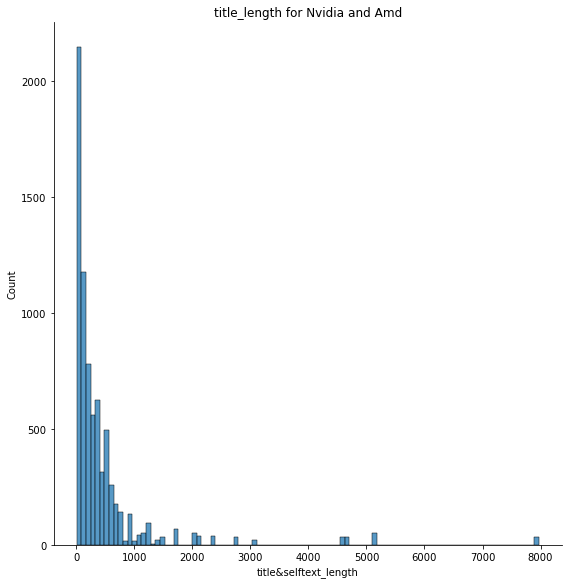

In [19]:
sns.displot(nvidia_amd['title&selftext_length'], kind = 'hist', bins = 100, height  = 8, aspect = 1);
plt.title('title_length for Nvidia and Amd');

To take a further look, I looked into the two reddits separately. I saw that nvidia seems more dense around the 0-1000 area compared to amd as well as it had the longest title and selft text length compared to amd. 

In [2]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,10))
sns.histplot(data=nvidia_amd[nvidia_amd['subreddit'] == 'nvidia'], x='title&selftext_length', ax = ax[0])
ax[0].title.set_text('Nvidia title and selftext length')
sns.histplot(data=nvidia_amd[nvidia_amd['subreddit'] == 'Amd'], x='title&selftext_length', ax = ax[1])
ax[1].title.set_text('Amd title and selftext length')
#help from Devin

NameError: name 'plt' is not defined

To make the displot that compares the two subreddit together needed a reindex so I did that before plotting the graph.

In [21]:
nvidia_amd.index.is_unique
nvidia_amd.reset_index(level=0, inplace=True)
#https://www.folkstalk.com/2022/10/reindex-pandas-dataframe-from-0-with-code-examples.html#:~:text=Approach%20%3A%201%20Import%20the%20Pandas%20module.%202,method.%205%20Display%20the%20DataFrame%20after%20each%20step.

This graph looks at both sets of subreddit together but compares the subreddit. As we can see, Amd was higher earlier on and then drops off, while when ot comes to Nvidia it was consistent and had the hight numbers.

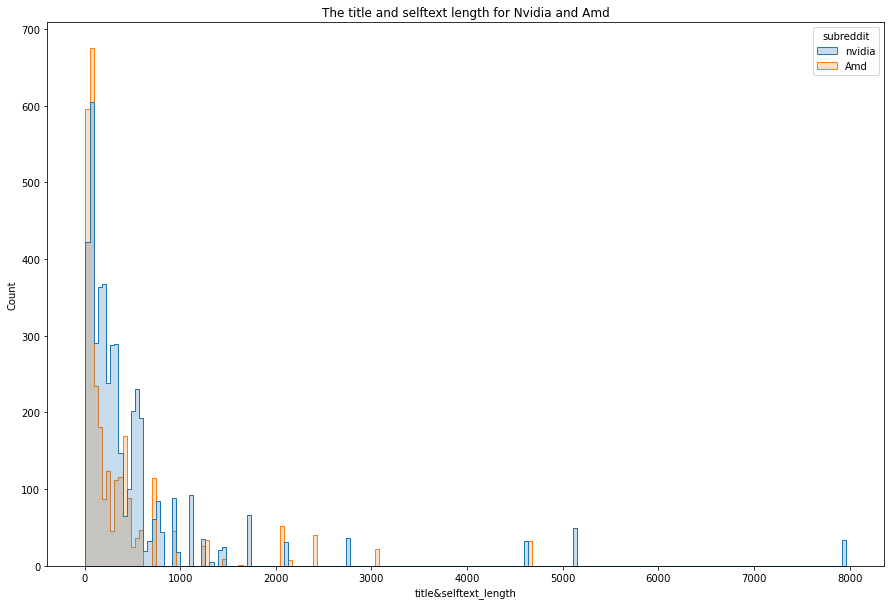

In [22]:
plt.figure(figsize = (15,10))
sns.histplot(
    nvidia_amd, x="title&selftext_length", hue="subreddit", element="step", common_norm=False,
)
plt.title('The title and selftext length for Nvidia and Amd');
#http://seaborn.pydata.org/generated/seaborn.histplot.html

When it comes to the number of words in the title and selftext we see the highest word count is 1182 and the lowest word count is 1.

In [23]:
nvidia_amd['title&selftext_word_count'].sort_values(ascending = False)


232     1182
1862    1182
3037    1182
2948    1182
2857    1182
        ... 
6790       1
4944       1
5368       1
6092       1
4891       1
Name: title&selftext_word_count, Length: 7498, dtype: int64

The looks at the word count of the title and the selftext ofr both subreddits. This is also very right skewed with most of the numbers being around 0-200. We can see one outlier in the data around 1200. 

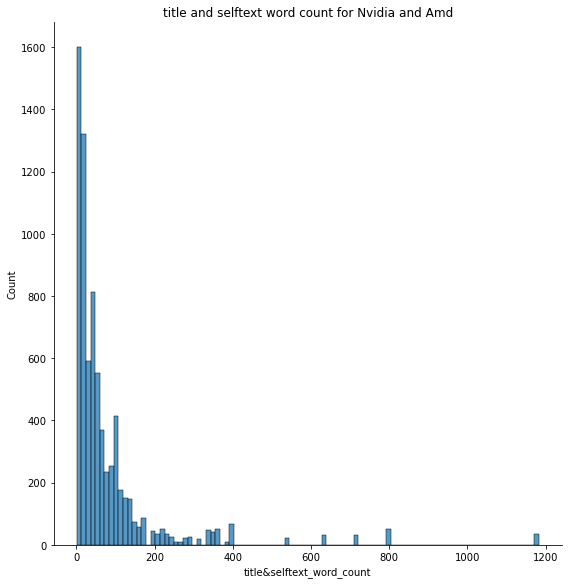

In [24]:
sns.displot(nvidia_amd['title&selftext_word_count'], kind = 'hist', bins = 100, height  = 8, aspect = 1)
plt.title('title and selftext word count for Nvidia and Amd');


I then looked at each of the subreddits separately and saw that nvidia had a wider range from 0-1200 while amd was 0-800. At the same time it can be seen that nvida is more dense around the 0-100 count compared to amd. 

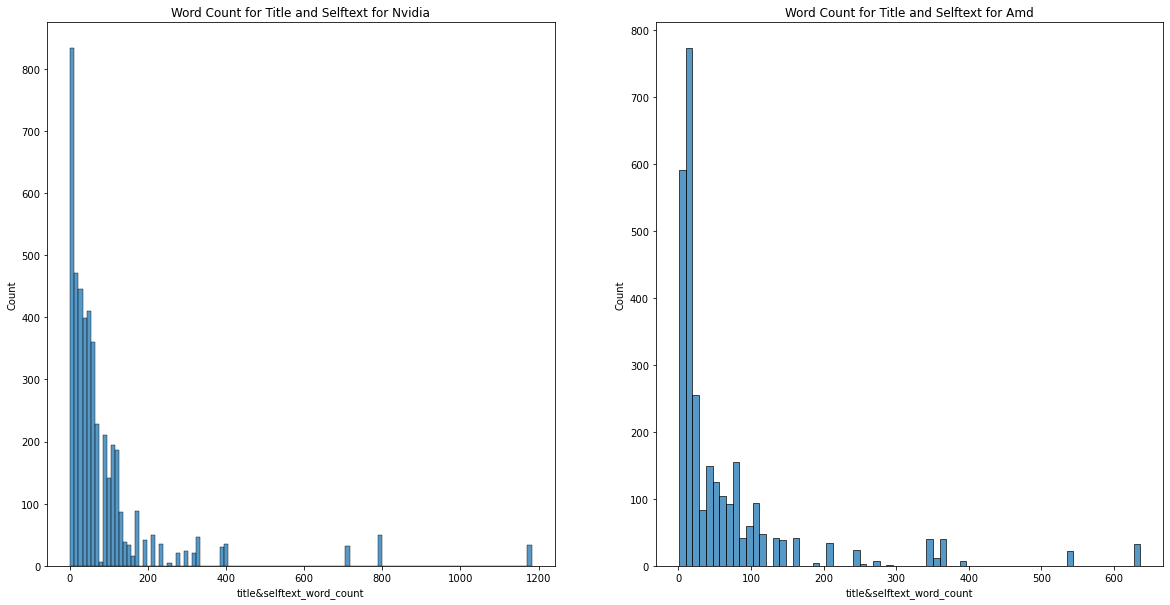

In [25]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,10))
sns.histplot(data=nvidia_amd[nvidia_amd['subreddit'] == 'nvidia'], x='title&selftext_word_count', ax = ax[0])
ax[0].title.set_text('Word Count for Title and Selftext for Nvidia')
sns.histplot(data=nvidia_amd[nvidia_amd['subreddit'] == 'Amd'], x='title&selftext_word_count', ax = ax[1]);
ax[1].title.set_text('Word Count for Title and Selftext for Amd')

Ths graph looks at the combined data for both subreddits and it shows that amd had the highest number of word count when it came to around the 0-100 area compared to nvidia. 

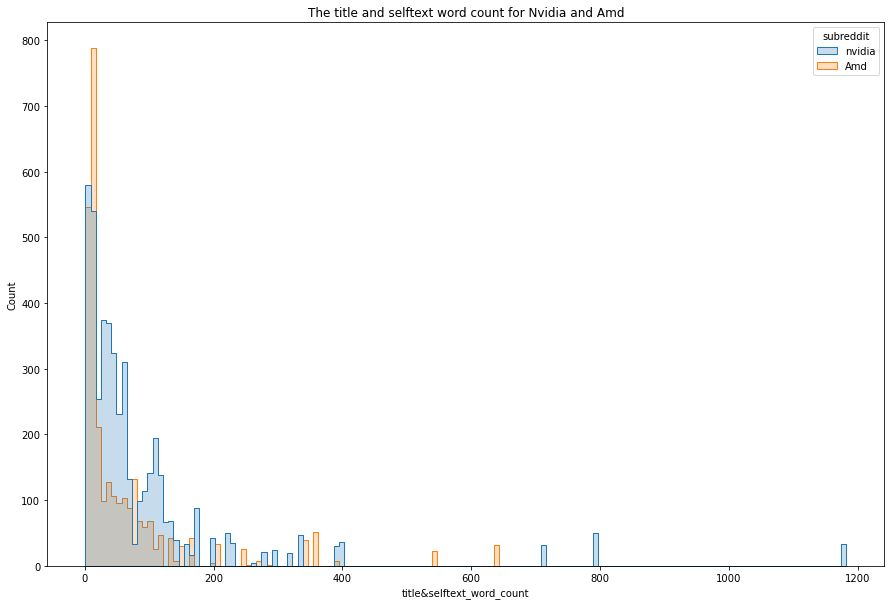

In [26]:
plt.figure(figsize = (15,10))
sns.histplot(nvidia_amd, x="title&selftext_word_count", hue="subreddit", element="step", common_norm=False)
plt.title('The title and selftext word count for Nvidia and Amd');
#http://seaborn.pydata.org/generated/seaborn.histplot.html

I then wanted to look at the number of unique authors from the entire dataset and saw that there were only 256 unique authors for the 10,000 posts that were looked at. That seems to be a really small number when it comes to acitivty on the two subreddits

In [27]:
len(nvidia_amd['author'].unique())


256

The average number of posts by each author seems to be around 30 title posts. 

In [28]:
nvidia_amd.groupby('author')['title'].count().mean()


29.2890625

In [29]:
nvidia_amd.corr()

,index,created_utc,is_self,title&selftext_length,title&selftext_word_count
index,1.000000,-0.233475,0.001362,0.007830,0.007634
created_utc,-0.233475,1.000000,-0.273096,-0.077552,-0.086420
is_self,0.001362,-0.273096,1.000000,0.326811,0.358922
title&selftext_length,0.007830,-0.077552,0.326811,1.000000,0.991330
title&selftext_word_count,0.007634,-0.086420,0.358922,0.991330,1.000000


The heatmap looks at the correlation numbers and it can be seen that title length and title word count are both around 0.99 which is a high correlation compared too all the other categories. 

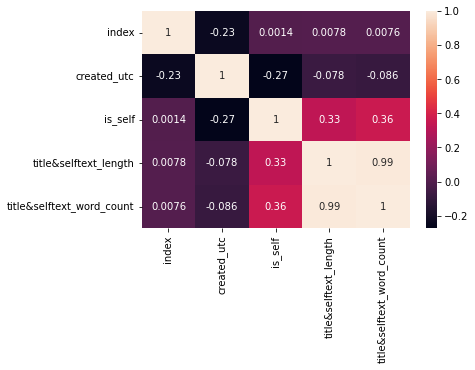

In [30]:
sns.heatmap(nvidia_amd.corr(), annot = True);

### EDA Analysis: 
After cleaning up the data and looking at the multiple histograms and correlation pots, I will be able to answer the problem statement. This is due to the fact that I'm able to believe with the cleaning that was done, it will be able to distinguish without having unnecessary noise. WHen it comes to the outliers, I will keep them due to the fact that they have content that will help in dinstinguishing the data as well. Overall, after comparing the data, I believe I can answer the problem statement present and help reddit. 

## Preprocessing and Modeling

### Lematizer

When it came with the preprocessing, I began by Lemmatizing the title and selftext columns with the regex token. 

In [31]:
i_tokenizer = RegexpTokenizer(r'\w+')
nvidia_amd['clean_title'] = nvidia_amd['title&self_text'].transform(i_tokenizer.tokenize)
#lesson notes

I instantiated the Lemmatizer that I'm interested in looking at. 

In [32]:
lemmatizer = WordNetLemmatizer()

I created a function in which I lemmatized the title and self content and made sure to join them together without being in a list form. I made a new columns for the lemmatized words and named it lemmatized. 

In [33]:
def lem(text):
    return " ".join([lemmatizer.lemmatize(i) for i in  i_tokenizer.tokenize(text)])
nvidia_amd['lemmatized'] = nvidia_amd['title&self_text'].apply(lem)
# help from rowan

### Stemmer

I instantied the stemmer that I would like to use as well. 

In [34]:
stemmer = PorterStemmer()

I created a function in which I stemmed the title and self content and made sure to join them together without being in a list form. I made a new columns for the stemmed words and named it stemmed. 

In [35]:
def port(stem):
    return " ".join([stemmer.stem(i) for i in  i_tokenizer.tokenize(stem)])
nvidia_amd['stemmed'] = nvidia_amd['title&self_text'].apply(port)
# help from rowan

### Stopwords

I then made a list of stop words that I saw that were used a lot in both groups and removed them from the data because they have no relevant importance to the two subreddits

In [36]:
newStopWords = ['like', 'wa','im', 'just', 'new', 'ha', 'would', 'need', 'vs', 'help', 'nvidia', 'amd']

stop_words = stopwords.words('english')

stop_words.extend(newStopWords)
#https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist#:~:text=You%20can%20simply%20use%20the%20append%20method%20to,words%2C%20as%20suggested%20by%20Charlie%20on%20the%20comments.

I made sure the new list of stop words were added in 

In [37]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Preprocessing Analysis:
After doing the lemmatization and stemmation and looking at both of the columns, I felt that Lemmatization used the right words when it came to explaining the ideas or the conversations in the columns. I felt Stemmation, didn't do a good job, so moving forward, I'm going to go with the lemmatization column. 

### CountVectorizer

I then did a countvectorizer with the lemmatization columns and included the stop_words

In [38]:
cvec = CountVectorizer(stop_words = stop_words)
cvec.fit(nvidia_amd['lemmatized'])
cvec_train = cvec.transform(nvidia_amd['lemmatized'])
cvec_train = pd.DataFrame(cvec_train.toarray(), columns = cvec.get_feature_names_out())


In [39]:
cvec_train

,01,0410,0611,075,099x,09x,0fps,0x116,10,100,...,z490,z77,zen,zen3,zen4,zero,zip,zipfest22,zone,zotac
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I then made a chart to look at the top 15 most common words for both of the subreddits. 

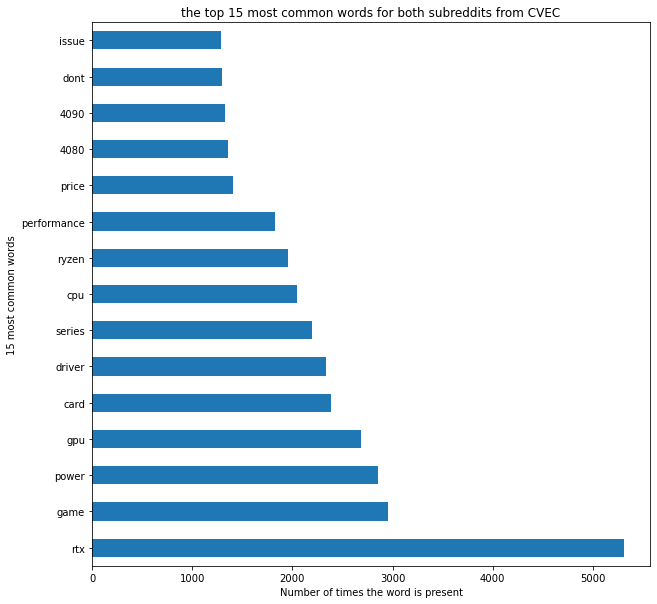

In [40]:
plt.figure(figsize = (10,10))
cvec_train.sum().sort_values(ascending = False).head(15).plot(kind = 'barh')
plt.title('the top 15 most common words for both subreddits from CVEC')
plt.xlabel('Number of times the word is present')
plt.ylabel('15 most common words'); 

I then did a countvectorizer for nvidia and graphed to see the common words in this subreddit

In [41]:
cvec = CountVectorizer(stop_words = stop_words)
cvec.fit(nvidia_df['title'])
cvec_nvidia = cvec.transform(nvidia_df['title'])
cvec_nvidia = pd.DataFrame(cvec_nvidia.toarray(), columns = cvec.get_feature_names_out())

From the plot, we can see that nvidia and rtx were the most common words in the subreddit which were rtx and 4090.

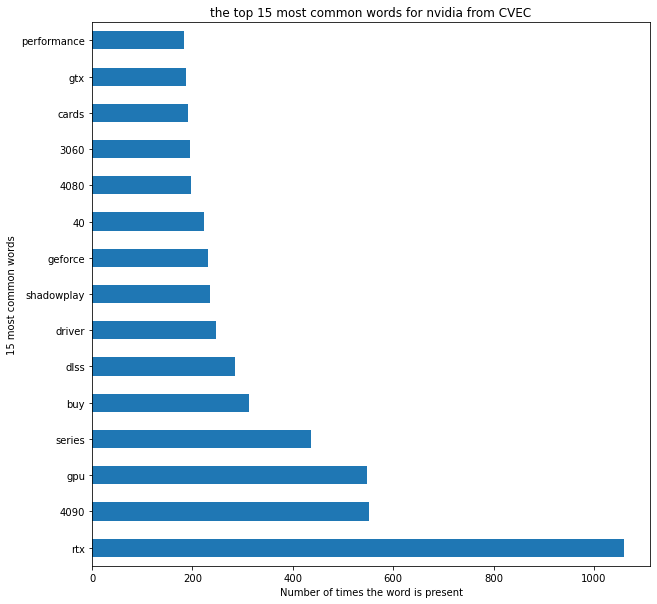

In [42]:
plt.figure(figsize = (10,10))
cvec_nvidia.sum().sort_values(ascending = False).head(15).plot(kind = 'barh')
plt.title('the top 15 most common words for nvidia from CVEC')
plt.xlabel('Number of times the word is present')
plt.ylabel('15 most common words'); 

I then did a countvectorizer on the amd dataset to see the most common words

In [43]:
cvec = CountVectorizer(stop_words = stop_words)
cvec.fit(amd_df['title'])
cvec_amd = cvec.transform(amd_df['title'])
cvec_amd = pd.DataFrame(cvec_amd.toarray(), columns = cvec.get_feature_names_out())

The most common words in this plot for amd was ryzen and 7950x

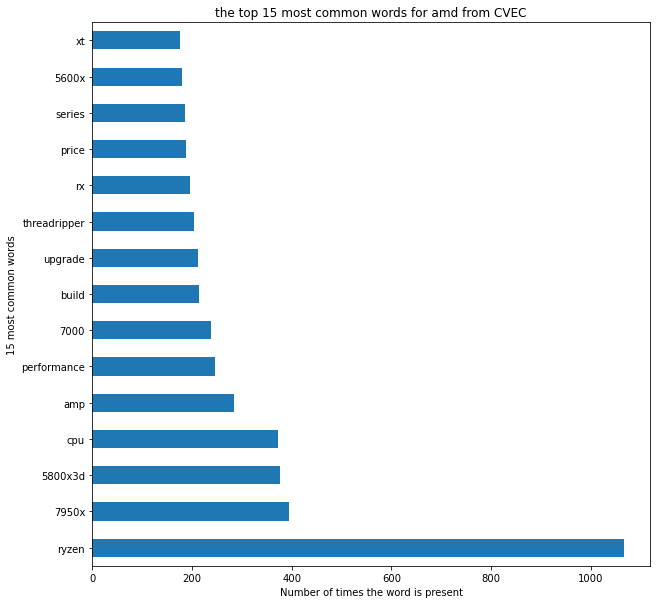

In [44]:
plt.figure(figsize = (10,10))
cvec_amd.sum().sort_values(ascending = False).head(15).plot(kind = 'barh')
plt.title('the top 15 most common words for amd from CVEC')
plt.xlabel('Number of times the word is present')
plt.ylabel('15 most common words'); 

### TfidfVectorizer

I then did a TfidfVectorizer onboth subreddits combined in the lemmatized form

In [45]:
tvec = TfidfVectorizer(stop_words = stop_words)
tvec_nvidia_amd = tvec.fit_transform(nvidia_amd['lemmatized'])
tvec_nvidia_amd = pd.DataFrame(tvec_nvidia_amd.toarray(), columns = tvec.get_feature_names_out())

I then made a graph to look at the top 15 most common words for both subreddits. When it comes to the most common words, they were rtx, gpu, and ryzen. 

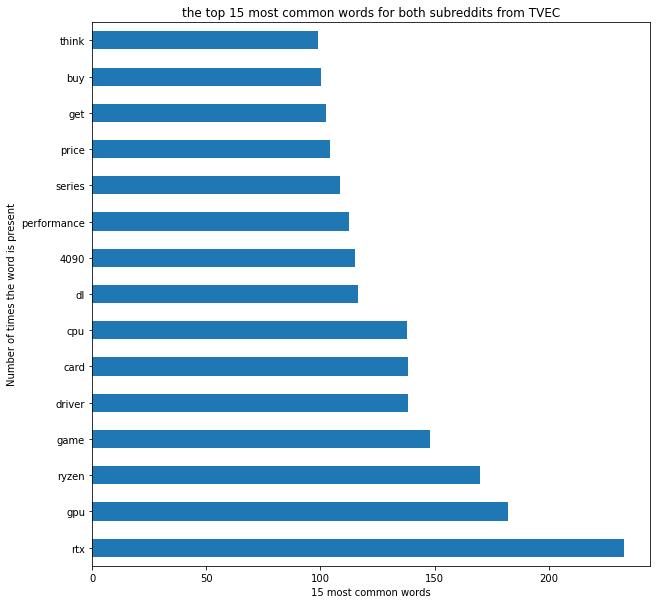

In [46]:
plt.figure(figsize = (10,10))
tvec_nvidia_amd.sum().sort_values(ascending = False).head(15).plot(kind = 'barh')
plt.title('the top 15 most common words for both subreddits from TVEC')
plt.xlabel('15 most common words')
plt.ylabel('Number of times the word is present');

I then did a TfidfVectorizer for the nvidia subreddit

In [47]:
tvec = TfidfVectorizer(stop_words = stop_words)
tvec_nvidia = tvec.fit_transform(nvidia_df['title'])
tvec_nvidia = pd.DataFrame(tvec_nvidia.toarray(), columns = tvec.get_feature_names_out())

I then made a graph to look at the top 15 most common words for the nvidia reddit. As presented from the graph, the most common words seem to be rtx and 4090. 

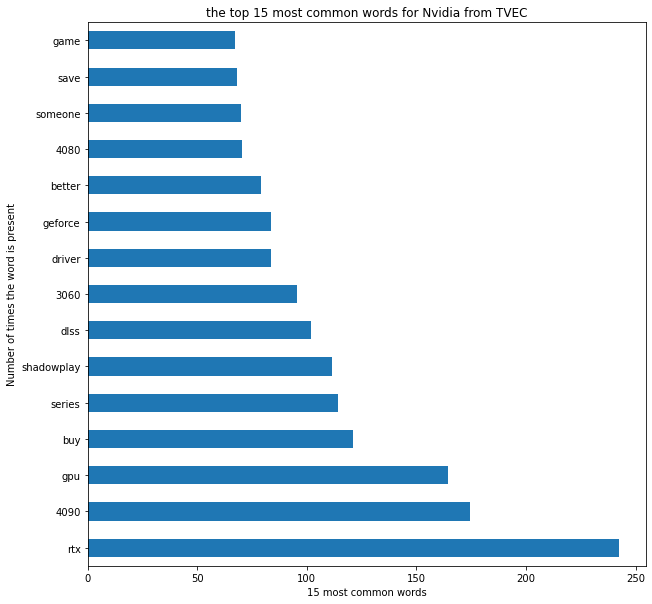

In [48]:
plt.figure(figsize = (10,10))
tvec_nvidia.sum().sort_values(ascending = False).head(15).plot(kind = 'barh')
plt.title('the top 15 most common words for Nvidia from TVEC')
plt.xlabel('15 most common words')
plt.ylabel('Number of times the word is present');

I then did a TfidfVectorizer for the amd subreddit

In [49]:
tvec = TfidfVectorizer(stop_words = stop_words)
tvec_amd = tvec.fit_transform(amd_df['title'])
tvec_amd = pd.DataFrame(tvec_amd.toarray(), columns = tvec.get_feature_names_out())

I then made a graph to look at the top 15 most common words for the amd reddit. As presented from the graph, the most common words seem to be ryzen and 5800x3d.

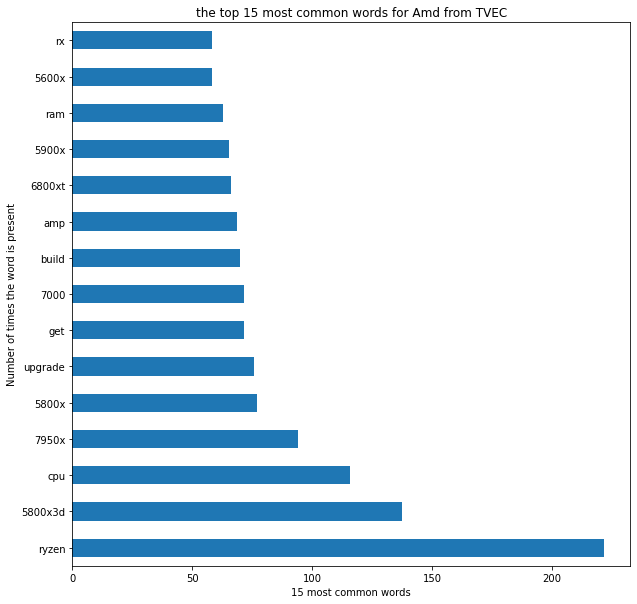

In [50]:
plt.figure(figsize = (10,10))
tvec_amd.sum().sort_values(ascending = False).head(15).plot(kind = 'barh')
plt.title('the top 15 most common words for Amd from TVEC')
plt.xlabel('15 most common words')
plt.ylabel('Number of times the word is present');

### Train/Test/Split

I began modeling the data by doing a train test split with the the X being the lemmatized columns and the y being the subreddit

In [51]:
X = nvidia_amd['lemmatized']
y = nvidia_amd['subreddit']

X_train, X_val,y_train, y_val = train_test_split(X,y, test_size = 0.35, random_state = 42, stratify = y) 

I wanted to see the X_val shape to make sure my confusion matrix adds up to 2625.

In [52]:
X_val.shape

(2625,)

### Baseline Model

As presented from the y_val we see that nvidia is 0.61 when compared to amd 0.389, our goal is to be able to beat this basline model and be able to make a better model. 

In [53]:
y_val.value_counts(normalize = True)

nvidia    0.610667
Amd       0.389333
Name: subreddit, dtype: float64

In [54]:
y_val.value_counts()

nvidia    1603
Amd       1022
Name: subreddit, dtype: int64

### Model

I began the modeling data by looking at CountVectorizer and looking at 3 different models which include Randomforest, Decision Tree, Logistic Regression. I kept the parameters for CVEC or CountVectorizer the same for each one of them to see how they change.

### Random Forest Classifier

I began by looking at countvectorizer and randomforest classifier and put a random state of 42.

In [55]:
cvrf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=42)),
])

Below are the paramters I used, I included max features, min df, max df, and ngram range for all of them

In [56]:
rfpipe_params = {
   'cvec__max_features' : [100,200,300,1000,10000],
    'cvec__min_df': [1,3,5,7],
    'cvec__max_df': [0.9, 0.95, 1.0],
    'cvec__ngram_range': [(1,1),(1,2)]
}

I then did a gridsearch for both the pipeline and parameters, fitted the model, then looked for the best score, the best params, and then printed out the scores for the training and testing sets. The scores were 1.0 and 0.9988, this indicates very high scores and there is no overfitting and underfitting.

In [57]:
gs_1 = GridSearchCV(cvrf_pipe, rfpipe_params, cv =5, verbose = 1, n_jobs = -1)

gs_1.fit(X_train, y_train)
print(gs_1.best_score_)
print(gs_1.best_params_)
print(f'gs score for training set: {gs_1.score(X_train, y_train)}')
print(f'gs score for training set: {gs_1.score(X_val, y_val)}')

Fitting 5 folds for each of 120 candidates, totalling 600 fits
1.0
{'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}
gs score for training set: 1.0
gs score for training set: 0.9988571428571429


I then made a confusion matrix to look at the true negatives, true positives, false positives, and false negatives. 

In [59]:
pred = gs_1.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, pred).ravel()

From the plot, we can see that the true negative was 1019 for AMD and the true positive was 1603. The false posiitve was 3 and the false negative was 0. As a result, this model did a good job of categorizing the true negative and the true positive, but there were still three that were in the false posiitve group. 

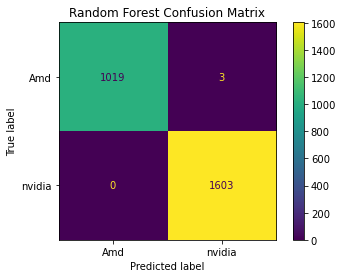

In [71]:
ConfusionMatrixDisplay.from_estimator(gs_1, X_val, y_val)
plt.title('Random Forest Confusion Matrix');

### Decision Tree

I then made a pipeline for CountVectorizer and Decision Tree. 

In [61]:
cvdc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('dc', DecisionTreeClassifier( random_state = 42)),
])

I kept similar parameters for decision tree and randomforest. 

In [62]:
cvdcpipe_params = {
    'cvec__max_features' : [100,200,300,1000,10000],
    'cvec__min_df': [1,3,5,7],
    'cvec__max_df': [0.9, 0.95, 1.0],
    'cvec__ngram_range': [(1,1),(1,2)]
}

I then made a gridsearch for the parameters and pipeline. I looked at the best score and the best params for it. Also looked at the train and test score from it we got 1.0 for the training and 0.9988 for the test score. These are really good results as we can see that its able to fit and score well. There is no overfit or underfit from what we can see. 

In [63]:
gs_2 = GridSearchCV(cvdc_pipe, cvdcpipe_params, cv =5, verbose = 1, n_jobs = -1)

gs_2.fit(X_train, y_train)
print(gs_2.best_score_)
print(gs_2.best_params_)
print(f'gs score for training set: {gs_2.score(X_train, y_train)}')
print(f'gs score for training set: {gs_2.score(X_val, y_val)}')

Fitting 5 folds for each of 120 candidates, totalling 600 fits
0.999794661190965
{'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}
gs score for training set: 1.0
gs score for training set: 0.9988571428571429


I then made a confusion matrix and saw similar results when it came to the randomforest in which the values are similar. The plot below shows true negative, false posiitve, false negative, and true positive. As we can see AMD had 1019 and nvidia had 1603. It seems there were three that were false posiitve.

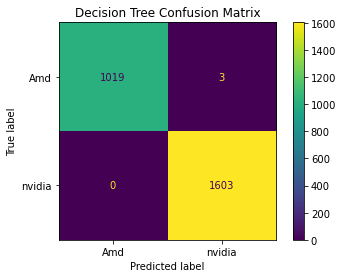

In [65]:
pred = gs_2.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, pred).ravel()
ConfusionMatrixDisplay.from_estimator(gs_2, X_val, y_val);
plt.title('Decision Tree Confusion Matrix');

### Logistic Regression

I then made a pipeline for CountVectorizer and Logistic Regression 

In [66]:
cvlr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression()),
])

I then kept similar params to see how it would affect the training and testing score. 

In [67]:
cvlrpipe_params = {
    'cvec__max_features' : [100,200,300,1000,10000],
    'cvec__min_df': [1,3,5,7],
    'cvec__max_df': [0.9, 0.95, 1.0],
    'cvec__ngram_range': [(1,1),(1,2)]
}

I Made a gridsearch for the pipeline and for the parameters. I looked at the best score and best params for this pipeline and then looked at the training and testing score. In this one, we can see that the score for the training set was 1.0 and the testing score was 1.0. This did better than both the randomforest and the decision tree Classifier.

In [68]:
gs_3 = GridSearchCV(cvlr_pipe, cvlrpipe_params, cv =5, verbose = 1, n_jobs = -1)

gs_3.fit(X_train, y_train)
print(gs_3.best_score_)
print(gs_3.best_params_)
print(f'gs score for training set: {gs_3.score(X_train, y_train)}')
print(f'gs score for testing set: {gs_3.score(X_val, y_val)}')

Fitting 5 folds for each of 120 candidates, totalling 600 fits
0.9997948717948718
{'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}
gs score for training set: 1.0
gs score for testing set: 1.0


I then made a confusion matrix to find that there were no false positives or false negatives from this model

In [69]:
pred = gs_3.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, pred).ravel()

The plot below shows true negative, false posiitve, false negative, and true positive. As we can see AMD had 1022 and nvidia had 1603. There were no false positives or false negatives as we can see from the confusion matrix.

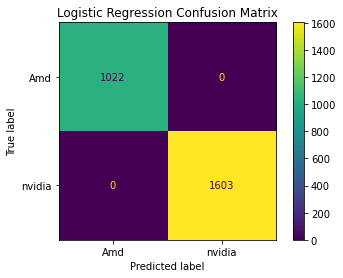

In [70]:
ConfusionMatrixDisplay.from_estimator(gs_3, X_val, y_val)
plt.title('Logistic Regression Confusion Matrix');

# Conclusion

From the three models that were presented above with countvectorizer, it can be seen that the logistic regression with countvectozier did the best. This can be seen from the fact that we ended up with no false positive or false negatives. In this model, we saw that there were 2,625 in total of true posiitve and true negative categories. The best parameters for logistic regression was max_df of 0.9, max_features of 1000, mind_df of 1, and ngram range of (1,1) When comparing that to randomforest and Decisiontree, they both came out with similar results, but were lower than Logistic Regression. They did have the same parameters as logistic regression. As it can be seen from the gs score for both of them. They had a training score of 1 and a testing score of .9988. These also portrayed really good models at the end in which only 3 were found in the false positive group. Overall, all three models did better than the baseline. Even though the data and models are showing good results, there needs to be a consideration on why the model is doing so well. From what can be seen, it seems that the two subreddits are very similar when it comes to what the companies do and what they are providing. In my further steps, I will need to look into more indept the similarities in words that exist between the two companies. Even though the model did a great job when it came to these two subreddits, it needs to be checked thorougly for other subreddits.  